<a href="https://colab.research.google.com/github/lfernandof/causal_inference/blob/main/slippery_grounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estrada sob mau tempo?

Aquaplanagem, menor visibilidade, risco de derrapamento: condições climáticas advsersas podem impactar a maneira como pessoas dirigem e a segurança na via. Além do senso comum, o manual de direção defensiva recomenda uma maior distância de seguimento e menor velocidade em condições de tempo adversas.

\\

Com este estudo, pretendo uma análise de inferência causal simples, buscando uma resposta tentativa ao seguinte questionamento: **Qual o impacto de intempéries climáticas na seriedade de acidentes em estradas brasileiras?**

\\

Para responder a essa questão eu vou utilizar o *paradigma de desfechos potenciais* (potential outcomes), também conhecido por *modelo causal de Neyman-Rubin*, aplicados a dados de acidentes de trânsito em território nacional, coletados entre 2015–2021 e compilados pela Polícia Rodoviária Federal (PRF), gentilmente [disponibilizados como um data set público no Kaggle](https://www.kaggle.com/datasets/mcamera/brazil-highway-traffic-accidents/data).


\\

---

\\


# Interações esperadas

Nossa interação causa-efeito alvo será entre as seguintes variáveis: condição climática e um "score de ilesos" (quociente entre o número de ilesos no acidente em uma ocorrência, coluna _ilesos_, e o número de passageiros envolvidos, coluna _pessoas_).

Também iremos nos atentar a outros fatores que podem influenciar um desfecho mais sério:
- o momento do dia (coluna *fase_dia*) pode afetar a atenção (via modulação da atenção dos motoristas por conta do ritmo circadiano), luminosidade e movimento na via;
- o tipo de pista (coluna *tipo_pista*), que pode determinar o tipo de manobra e o envolvimento de outros veículos;
- a morfologia da pista (coluna *tracado_via*), uma vez que a presença de curvas e cruzamentos podem exacerbar as dificuldades em climas adversos;
- a classificação da via (urbana ou rural; coluna *uso_solo*) pode influenciar a velocidade de resgate e atendimento, influenciando o desfecho de saúde dos envolvidos.

\\

---

\\

**Algumas inspiraçoes teóricas:**

Igelström E, Craig P, Lewsey J, Lynch J, Pearce A, Katikireddi SV. _Causal inference and effect estimation using observational data._ J Epidemiol Community Health. 2022 Nov;76(11):960–6. doi: 10.1136/jech-2022-219267. Epub 2022 Sep 6. PMCID: PMC9554068.

K. Narita, J.D. Tena, C. Detotto. _"Causal inference with observational data: A tutorial on propensity score analysis"_ The Leadership Quarterly, Volume 34, Issue 3, June 2023, 101678. DOI: 10.1016/j.leaqua.2023.101678

# Configurações e preparação

In [1]:
# INSTALLS

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.9 MB/s eta 0:00:00


In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json
import scipy
import seaborn as sns
import shap

# ACCESS TO DATA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# CONFIGS
plt.rcParams.update({'font.size': 16})

#### Agregar os dados de vários anos em um único DataFrame

In [3]:
#anos = list(range(2007,2022,1))
anos = list(range(2015,2022,1))

In [4]:
acidentes = [] # todos acidentes registrados entre 2007-2021
for ano in anos:
  acidentes_ano = pd.read_csv(f'./drive/MyDrive/data/acidentes/datatran{ano}.csv', sep = ';', encoding = 'latin1', decimal = ',').copy()
  acidentes_ano['ano'] = ano

  acidentes.append(acidentes_ano)
  del acidentes_ano # limpar a memória

In [5]:
acidentes_global = pd.concat(acidentes).copy()
print(f'Há {len(acidentes_global)} acidentes registrados no período 2007-2021')

Há 539277 acidentes registrados no período 2007-2021


# Modificações previstas no conjunto de dados

1. Criar uma coluna "score de fatalidade" como delineado acima (vítimas fatais/número de envolvidos no acidente) ✔
2. Omitir as demais colunas (i.e. _drop_ em uma cópia do dataframe) ✔
3. Remover linhas com valor nulo para as variáveis de interesse (no futuro pode-se fazer uma inputação; agora não disponho de tanto tempo); ✔
4. Transformar os rótulos textuais da condição climática para um score: 1 = {céu claro, sol}, 2 = {nublado, vento, garoa/chuvisco}, 3 = {chuva, neve, nevoeiro/neblina, granizo}; ✔
5. Fazer transformações similares de rótulo textual para integer. Convenção: _valores menores serão imputados a condições menos adversas (e.g. via reta, pleno dia, via urbana, etc.) e valores mais altos a condições mais adversas (e.g. pista curva, plena noite, via rural, etc.). ✔

In [6]:
# 1. Criar uma coluna "score de fatalidade" como delineado acima (vítimas fatais/número de envolvidos no acidente) ✔
acidentes_global['score_fatalidade'] = acidentes_global['mortos']/acidentes_global['pessoas']
acidentes_global['score_ilesos'] = acidentes_global['ilesos']/acidentes_global['pessoas']

In [7]:
# 2. Omitir as demais colunas

target_vars = ['fase_dia','condicao_metereologica','tipo_pista','tracado_via','score_ilesos','score_fatalidade']

acidentes_df = acidentes_global[target_vars].copy()

In [8]:
# 3. Remover linhas com valor nulo para as variáveis de interesse (no futuro pode-se fazer uma inputação; agora não disponho de tanto tempo)

# O dataframe tem variação nesses rótulos por conta de unicode/capitalização. Vamos modificar isso tirando os acentos e capitalizando tudo
#for col in ['condicao_metereologica','fase_dia','tipo_pista','tracado_via','uso_solo']:
for col in ['condicao_metereologica','fase_dia','tipo_pista','tracado_via']:
  acidentes_df[col] = acidentes_df[col].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  acidentes_df[col] = acidentes_df[col].str.upper()

#print(acidentes_df.condicao_metereologica.unique()) # A var. causal tem valores NaN e strings '(null)' e 'Ignorada' que não são informativos e vamos remover as linhas que os contenham
print('# antes da filtragem:',len(acidentes_df))

# antes da filtragem: 539277


In [9]:
# Remover linhas cujo valor na coluna-alvo esteja na lista de valores passada
def filter_entry_by_column_value(df, column, values):
  lines_with_condition = df[column].isin(values)
  return df[~lines_with_condition].copy()

# Variável de interesse (causal)
acidentes_df = filter_entry_by_column_value(acidentes_df,'condicao_metereologica',values=['(NULL)','IGNORADA','IGNORADO',np.nan])

# Outras variáveis
acidentes_df = filter_entry_by_column_value(acidentes_df,'tracado_via',values=['(NULL)','NAO INFORMADO',np.nan])
acidentes_df = filter_entry_by_column_value(acidentes_df,'tipo_pista',values=['(NULL)'])
acidentes_df = filter_entry_by_column_value(acidentes_df,'fase_dia',values=['(NULL)',np.nan])
#acidentes_df = filter_entry_by_column_value(acidentes_df,'uso_solo',values=['NAO','SIM']) # não sabemos o que são as tags "não"/"sim"

#print(acidentes_df.condicao_metereologica.unique())
print('# depois da filtragem:',len(acidentes_df))

# depois da filtragem: 497254


In [10]:
# 4. Transformar os rótulos textuais da condição climática para um score: 1 = {céu claro, sol}, 2 = {nublado, vento, garoa/chuvisco}, 3 = {chuva, neve, nevoeiro/neblina, granizo}

# Definir os novos rótulos

# Condições metereológicas:
condicoes_dict = {'CEU CLARO':0,'SOL':0,
                  'NUBLADO':1,'VENTO':1,'GAROA/CHUVISCO':1,
                  'CHUVA':2,'NEVOEIRO/NEBLINA':2,'GRANIZO':2,'NEVE':2}

# Uso do solo:
uso_solo_dict = {'RURAL': 0, 'URBANO':1}

# Fase do dia:
fase_dia_dict = {'PLENO DIA': 0,
                 'AMANHECER':1,'ANOITECER':1,
                 'PLENA NOITE':2}

# Tipo de pista:
tipo_pista_dict = {'SIMPLES': 0,'DUPLA': 1,'MULTIPLA': 2} # não me convenci imediatamente de que uma oferece mais periculosidade que a outra então por enquanto deixo todas com mesmo valor

# Traçado da via:
# Aplicar apenas à reta um valor menor (decisão arbitrária)
tracados_dict = {tracado:1 for tracado in acidentes_df.tracado_via.unique()}
tracados_dict.update({'RETA':0})

# Fazer as substituições
acidentes_df.replace(to_replace={'condicao_metereologica':condicoes_dict},inplace=True)
acidentes_df.replace(to_replace={'uso_solo':uso_solo_dict},inplace=True)
acidentes_df.replace(to_replace={'tracado_via':tracados_dict},inplace=True)
acidentes_df.replace(to_replace={'fase_dia':fase_dia_dict},inplace=True)
acidentes_df.replace(to_replace={'tipo_pista':tipo_pista_dict},inplace=True)

# Algumas visualizações

In [31]:
acidentes_df.columns

Index(['fase_dia', 'condicao_metereologica', 'tipo_pista', 'tracado_via',
       'score_ilesos', 'score_fatalidade'],
      dtype='object')

Text(0.5, 1.0, 'Ilesos com relação à condição climática\n e momento do dia (luminosidade)')

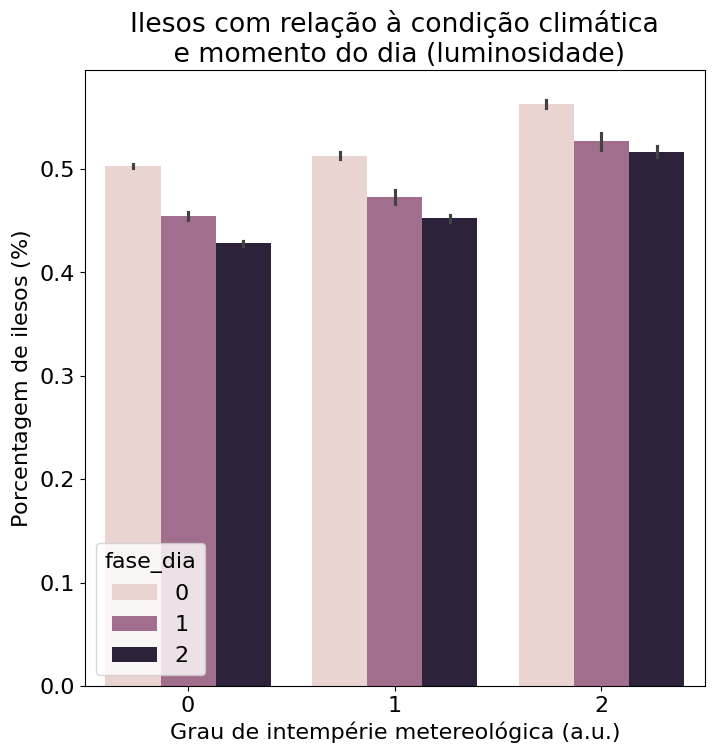

In [41]:
plt.figure(figsize=(8,8))
sns.barplot(data = acidentes_df, x = 'condicao_metereologica', y = 'score_ilesos',hue='fase_dia')
plt.xlabel('Grau de intempérie metereológica (a.u.)')
plt.ylabel(r'Porcentagem de ilesos ($\%$)')
plt.title('Ilesos com relação à condição climática\n e momento do dia (luminosidade)')

Text(0.5, 1.0, 'Ilesos com relação à condição climática\n e traçado da via (morfologia)')

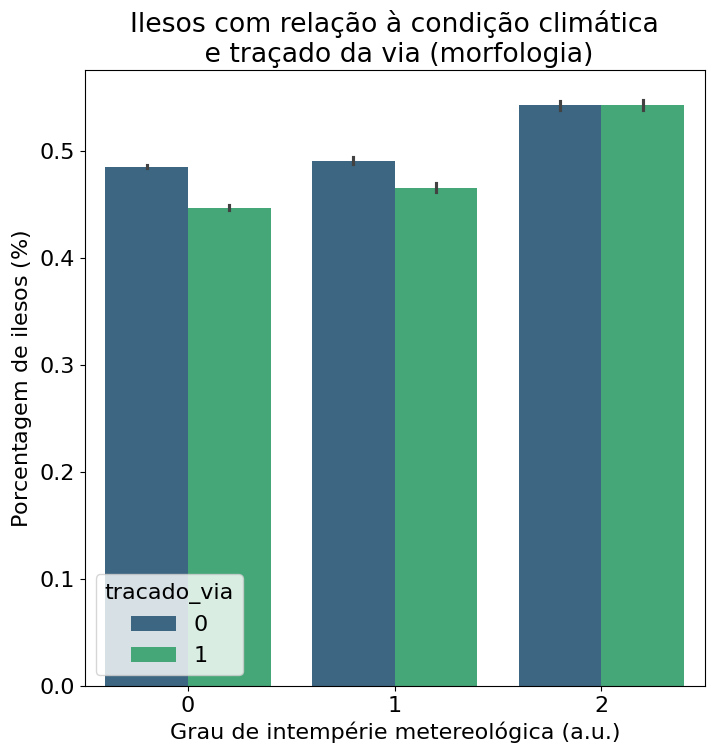

In [51]:
plt.figure(figsize=(8,8))
sns.barplot(data = acidentes_df, x = 'condicao_metereologica', y = 'score_ilesos',hue='tracado_via',palette='viridis')
plt.xlabel('Grau de intempérie metereológica (a.u.)')
plt.ylabel(r'Porcentagem de ilesos ($\%$)')
plt.title('Ilesos com relação à condição climática\n e traçado da via (morfologia)')

Text(0.5, 1.0, 'Ilesos com relação à condição climática\n e tipo de pista (simples, dupla, múltipla)')

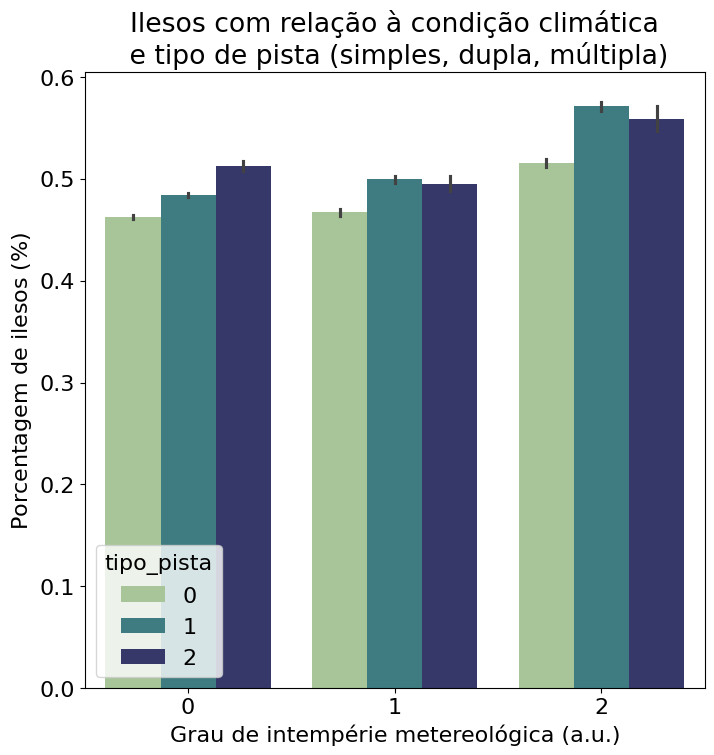

In [52]:
plt.figure(figsize=(8,8))
sns.barplot(data = acidentes_df, x = 'condicao_metereologica', y = 'score_ilesos',hue='tipo_pista',palette='crest')
plt.xlabel('Grau de intempérie metereológica (a.u.)')
plt.ylabel(r'Porcentagem de ilesos ($\%$)')
plt.title('Ilesos com relação à condição climática\n e tipo de pista (simples, dupla, múltipla)')

# Estudo ingênuo do efeito médio do tratamento ("Naïve" ATE)

A ocorrência de chuva, neblina ou outras intempéries climáticas é um evento aleatório, que independe das demais variáveis acerca do trajeto ou viagem, e.g. traçado da via. Uma análise trivial seria simplesmente comparar os acidentes que ocorreram sob bom e mau tempo.

Uma métrica simples para essa comparação é o ATE: average treatment effect, efeito médio do tratamento. Ele é simplesmente a diferença entre as médias de cada grupo, o grupo controle (que não teve intervenção, i.e. bom tempo) e o grupo tratamento (que teve intervenção, i.e. mau tempo).

Se pudéssemos observar pra cada observação $i$ tanto o valor da variável-alvo (nesse caso, porcentagem de ilesos no acidente) sob bom tempo $y_i(mau \; tempo = 0)$ quanto sob mau tempo $y_i(mau \; tempo = 1)$ bastaria que fizéssemos a média das diferenças em todas as observações:

\begin{equation}
ATE = \frac{1}{N} \sum_i \big ( y_i(mau \; tempo = 1) - y_i(mau \; tempo = 0) \big )
\end{equation}

Como não dispomos do desfecho simultâneo para uma observação com e sem tratamento esse $ATE$ pode ser calculado como a média de todas observações em cada condição:

\begin{equation}
\widehat{ATE} = \frac{1}{N_i} \sum_i y_i(mau \; tempo = 1) - \frac{1}{N_j} \sum_j y_j(mau \; tempo = 0) \\
\quad \quad = \mathbb{E}[y_i(mau \; tempo = 1)] - \mathbb{E}[y_j(mau \; tempo = 0)]
\end{equation}

onde $i$ são as ocorrências no grupo com intervenção (direção sob mau tempo) e $j$ são as ocorrências no grupo sem (bom tempo).

In [11]:
grupo_controle = acidentes_df.query('condicao_metereologica < 1').copy()
grupo_intervencao = acidentes_df.query('condicao_metereologica >= 1').copy()

print('Observações no grupo controle: ',len(grupo_controle),'\nObservações no grupo intervenção: ',len(grupo_intervencao))

Observações no grupo controle:  319331 
Observações no grupo intervenção:  177923


Como ambos conjuntos são grandes ($>100.000$ observações), aplica-se a lei dos grandes números e é justificável uma média.

A diferença no número de observações em cada grupo é bem grande, ~1 mi observações. Em etapas futuras pode-se fazer um controle com reamostragem (e.g. bootstrapping) da amostra maior.

Sem mais delongas, calculemos o ATE.

In [12]:
media_controle = grupo_controle.score_ilesos.mean()
media_intervencao = grupo_intervencao.score_ilesos.mean()
print(media_controle,media_intervencao)

0.4751135201661982 0.5085391855123654


In [13]:
ate = media_intervencao - media_controle
print('ATE ',ate)

ATE  0.033425665346167255


# Pareamento de score de propensidade (PSM) e efeito médio do tratamento (ATE)

Contudo, nosso conjunto de dados pode estar enviesado. Diferentemente de ensaios clínicos aleatorizados, temos apenas observações de eventos. Pode ser que hajam, por exemplo, mais vítimas em acidentes na chuva porque eles mais frequentemente acontecerem em pontes ou curvas.

\

Para garantir que o efeito observado seja atribuível exclusivamente à intempérie metereológica podemos nos inspirar na técnica de pareamento de score de propensidade (tradução livre de propensity score matching, PSM). Formam-se pares entre itens no grupo de intervenção e controle que sejam similares em todas demais variáveis confusoras (i.e. outros fatores que influenciam o desfecho, e.g. traçado da via no nosso caso) exceto na variável cujo efeito causal no desfecho queremos avaliar.

\

Ela funciona da seguinte maneira:


1. Atribui a cada observação um identificador com relação às variáveis confusoras (e.g. com um score calculado a partir de uma regressão logística)
2. Encontra pares P_i = {intervenção, controle} de observações em cada condição que tenham identificadores parecidos (e.g. scores similares) utilizando alguma técnica (e.g. vizinhos próximos ou distância num espaço N-dimensional) e armazena cada elemento do par em uma distribuição correspondente à condição (e.g. a observação do grupo de intervenção vai pra uma lista de observações do grupo controle já pareadas; similarmente pra observação do grupo controle)
3. Pareados todos elementos no grupo intervenção, verifica-se se a distribuição de cada variável confusora é similar em ambas listas (e.g. através de um teste t comparando as médias)
4. Se as covariâncias nos dois conjuntos for similar, a ATE calculada usando as observações em cada conjunto vai ser atribuível tão somente à variável causal


In [14]:
from scipy.spatial import KDTree

In [15]:
# cria a estrutura de dados árvore k-d com dados do grupo controle, permitindo uma varredura eficiente por proximidade com base nas dimensões de interesse (variáveis confusoras)
kd_controle = KDTree(grupo_controle.drop(columns=['score_ilesos','score_fatalidade','condicao_metereologica']).values)

In [16]:
# buscar na árvore k-d gerada com os dados do grupo controle o id da observação mais próxima de cada observação no grupo intervenção (efetivamente: pares {controle, intervenção})
# e armazenar isso em um dataframe
controle_pareado = grupo_controle.iloc[kd_controle.query(grupo_intervencao.drop(columns=['score_ilesos','score_fatalidade','condicao_metereologica']).values, k=1)[-1]]
controle_pareado

,fase_dia,condicao_metereologica,tipo_pista,tracado_via,score_ilesos,score_fatalidade
35628,2,0,1,0,0.500000,0.0
35628,2,0,1,0,0.500000,0.0
35628,2,0,1,0,0.500000,0.0
35628,2,0,1,0,0.500000,0.0
35628,2,0,1,0,0.500000,0.0
...,...,...,...,...,...,...
97343,2,0,0,1,0.500000,0.5
19961,0,0,2,0,1.000000,0.0
66127,0,0,1,0,0.500000,0.0
17424,2,0,0,0,1.000000,0.0


In [17]:
grupo_intervencao

,fase_dia,condicao_metereologica,tipo_pista,tracado_via,score_ilesos,score_fatalidade
2,2,1,1,0,1.000000,0.000000
4,2,1,1,0,1.000000,0.000000
8,2,1,1,0,1.000000,0.000000
9,2,1,1,0,1.000000,0.000000
10,2,1,1,0,1.000000,0.000000
...,...,...,...,...,...,...
30880,2,1,0,1,0.142857,0.000000
30886,0,2,2,0,0.500000,0.000000
30890,0,1,1,0,0.000000,0.222222
30895,2,2,0,0,0.000000,0.166667


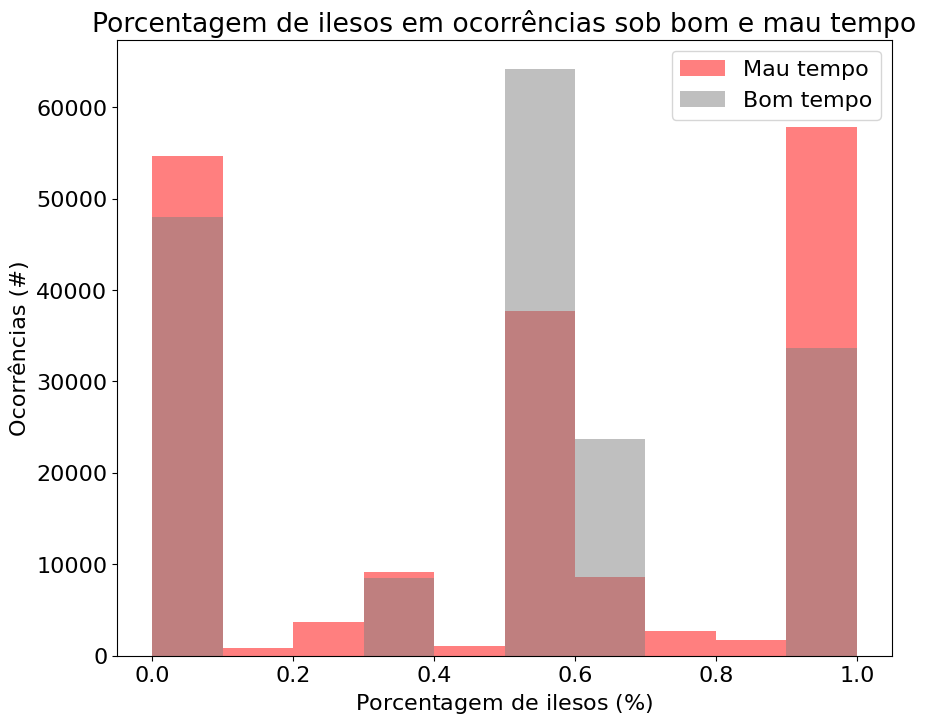

In [54]:
plt.figure(figsize=(10,8))
plt.hist(grupo_intervencao.score_ilesos.values,color='red',label='Mau tempo',alpha=0.5)
plt.hist(controle_pareado.score_ilesos.values,color='grey',label='Bom tempo',alpha=0.5)
plt.title('Porcentagem de ilesos em ocorrências sob bom e mau tempo')
plt.xlabel(r'Porcentagem de ilesos ($\%$)')
plt.ylabel('Ocorrências (#)')
plt.legend()
plt.show()

In [22]:
media_controle_pareado = controle_pareado.score_ilesos.mean()
print(media_controle_pareado,media_intervencao)

0.4739484683449207 0.5085391855123654


In [23]:
ate_pareado = media_intervencao - media_controle_pareado
print('ATE ',ate_pareado)

ATE  0.03459071716744472


# O que influencia?

0.33446078462353634


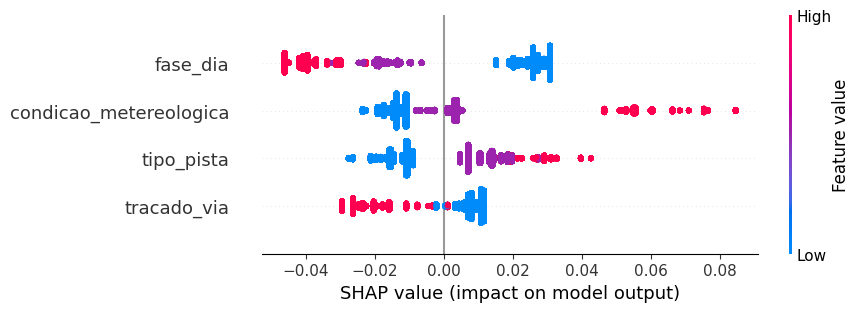

In [27]:
y = acidentes_df.score_ilesos

target_features = ['fase_dia', 'condicao_metereologica', 'tipo_pista', 'tracado_via']

x = acidentes_df[target_features]

from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_x, val_x, train_y, val_y = train_test_split(x, y,random_state = 0)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_x, train_y)
acidentes_pred = forest_model.predict(val_x)
print(mean_absolute_error(val_y, acidentes_pred))

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(forest_model)

explanation = explainer(val_x)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
shap.plots.beeswarm(explanation)

# Próximos passos
- Avaliar outras métricas no conjunto de dados (e.g. latitude/longitude)
- Atestar a significância desse resultado (bootstrapping?)